# Entraînement MobileNetV3 pour Classification d'Épices Marocaines
## Projet Master - Transfer Learning avec PyTorch

**Dataset:** 2200 images, 11 classes d'épices marocaines  
**Architecture:** MobileNetV3-Large (pré-entraîné sur ImageNet)  
**Framework:** PyTorch avec GPU support

---

### 📋 Plan d'Exécution:
1. Configuration et imports
2. Chargement des statistiques EDA
3. Configuration des DataLoaders avec augmentation
4. Construction du modèle MobileNetV3
5. Configuration de l'entraînement
6. Boucle d'entraînement avec early stopping
7. Évaluation et métriques
8. Visualisation des résultats

## 1. Configuration et Installation

In [28]:
# Installation des packages (pour Google Colab)
# Décommentez si vous êtes sur Colab
# !pip install -q torch torchvision tqdm matplotlib seaborn scikit-learn pandas

#print("Vérification de l'environnement...")

In [ ]:
# Imports
import os
import json
import time
import copy
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports terminés")

✓ Imports terminés


In [2]:
# Vérification GPU
print("="*80)
print("CONFIGURATION MATÉRIELLE")
print("="*80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice utilisé: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("⚠ GPU non disponible - L'entraînement sera plus lent sur CPU")

print(f"\nPyTorch version: {torch.__version__}")
print(f"Torchvision version: {torch.__version__}")

CONFIGURATION MATÉRIELLE

Device utilisé: cpu
⚠ GPU non disponible - L'entraînement sera plus lent sur CPU

PyTorch version: 2.10.0+cpu
Torchvision version: 2.10.0+cpu


## 2. Configuration des Chemins et Hyperparamètres

In [3]:
# ============================================================================
# CONFIGURATION - MODIFIEZ CES CHEMINS
# ============================================================================

# Chemins du dataset (chemins absolus recommandés)
BASE_PATH = Path('C:/Users/zaineb/Desktop/spices 5-2')
DATASET_PATH = BASE_PATH / 'dataset' / 'splits'  # Chemin vers votre dataset (train, val, test)
EDA_RESULTS_PATH = BASE_PATH / 'eda_results'  # Dossier des résultats EDA

# Création des dossiers de sortie
MODELS_DIR = BASE_PATH / 'models'
RESULTS_DIR = BASE_PATH / 'mobilenet_results'
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# Vérifier que les dossiers de données existent
print("Vérification des chemins:")
print(f"  Dataset: {DATASET_PATH} - {'✓' if DATASET_PATH.exists() else '✗'}")
print(f"  EDA Results: {EDA_RESULTS_PATH} - {'✓' if EDA_RESULTS_PATH.exists() else '✗'}")

# Classes d'épices (11 classes - anis inclus!)
SPICE_CLASSES = [
    'anis', 'cannelle', 'carvi', 'clou_girofle', 'cubebe',
    'cumin', 'curcuma', 'gingembre', 'paprika', 'poivre noir', 'safran'
]

NUM_CLASSES = len(SPICE_CLASSES)

# ============================================================================
# HYPERPARAMÈTRES
# ============================================================================

CONFIG = {
    # Données
    'image_size': 224,  # Réduit à 224 pour MobileNetV3 standard
    'batch_size': 16,   # Réduit pour éviter problèmes mémoire sur CPU
    'num_workers': 0,   # 0 pour Windows (évite problèmes de multiprocessing)
    
    # Entraînement
    'num_epochs': 20,   # Réduit pour démonstration
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    
    # Transfer Learning
    'freeze_backbone': True,  # Geler les couches pré-entraînées au début
    'unfreeze_epoch': 5,       # Epoch où on dégèle le backbone
    'unfreeze_lr': 0.0001,     # Learning rate après dégel
    
    # Early Stopping
    'patience': 5,             # Nombre d'epochs sans amélioration
    'min_delta': 0.001,        # Amélioration minimale
    
    # Augmentation
    'use_augmentation': True,
    
    # Seed pour reproductibilité
    'seed': 42
}

print("\nConfiguration chargée:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Vérification des chemins:
  Dataset: C:\Users\zaineb\Desktop\spices 5-2\dataset\splits - ✓
  EDA Results: C:\Users\zaineb\Desktop\spices 5-2\eda_results - ✓

Configuration chargée:
  image_size: 224
  batch_size: 16
  num_workers: 0
  num_epochs: 20
  learning_rate: 0.001
  weight_decay: 0.0001
  freeze_backbone: True
  unfreeze_epoch: 5
  unfreeze_lr: 0.0001
  patience: 5
  min_delta: 0.001
  use_augmentation: True
  seed: 42


In [4]:
# Seed pour reproductibilité
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG['seed'])
print(f"✓ Seed fixé à {CONFIG['seed']} pour reproductibilité")

✓ Seed fixé à 42 pour reproductibilité


## 3. Chargement des Statistiques de Normalisation

In [5]:
# Charger les statistiques calculées lors de l'EDA
norm_stats_path = EDA_RESULTS_PATH / 'normalization_stats.json'

if norm_stats_path.exists():
    try:
        with open(norm_stats_path, 'r', encoding='utf-8') as f:
            norm_stats = json.load(f)
        
        MEAN = [norm_stats['mean']['r'], norm_stats['mean']['g'], norm_stats['mean']['b']]
        STD = [norm_stats['std']['r'], norm_stats['std']['g'], norm_stats['std']['b']]
        
        print("✓ Statistiques de normalisation chargées depuis l'EDA:")
        print(f"  Mean: {[f'{m:.4f}' for m in MEAN]}")
        print(f"  Std:  {[f'{s:.4f}' for s in STD]}")
    except (FileNotFoundError, json.JSONDecodeError, KeyError):
        print("⚠ Erreur lors de la lecture des statistiques, utilisation des valeurs ImageNet")
        MEAN = [0.485, 0.456, 0.406]
        STD = [0.229, 0.224, 0.225]
else:
    print("⚠ Fichier de statistiques non trouvé:")
    print(f"  Chemin attendu: {norm_stats_path}")
    print("  Utilisation des valeurs ImageNet par défaut")
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

✓ Statistiques de normalisation chargées depuis l'EDA:
  Mean: ['0.6029', '0.5535', '0.5049']
  Std:  ['0.1871', '0.2081', '0.2310']


## 4. Création du Dataset Custom et DataLoaders

In [6]:
class SpiceDataset(Dataset):
    """
    Dataset personnalisé pour les épices marocaines.
    """
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir: Chemin vers le dossier dataset_spices
            split: 'train', 'val', ou 'test'
            transform: Transformations à appliquer
        """
        self.root_dir = Path(root_dir) / split
        self.transform = transform
        self.classes = sorted(SPICE_CLASSES)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Collecter tous les chemins d'images
        self.samples = []
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            if not class_dir.exists():
                continue
            
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                for img_path in class_dir.glob(ext):
                    self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        print(f"✓ {split.capitalize()} set: {len(self.samples)} images chargées")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Charger l'image
        image = Image.open(img_path).convert('RGB')
        
        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ Classe SpiceDataset définie")

✓ Classe SpiceDataset définie


In [7]:
# Définir les transformations

# Transformations pour l'entraînement (avec augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Transformations pour validation/test (sans augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print("✓ Transformations définies")
print("\nAugmentations du training set:")
print("  - Random Horizontal Flip (50%)")
print("  - Random Vertical Flip (30%)")
print("  - Random Rotation (±20°)")
print("  - Color Jitter")
print("  - Random Affine (translation, scale)")

✓ Transformations définies

Augmentations du training set:
  - Random Horizontal Flip (50%)
  - Random Vertical Flip (30%)
  - Random Rotation (±20°)
  - Color Jitter
  - Random Affine (translation, scale)


In [8]:
# Créer les datasets
print("\nCréation des datasets...\n")

train_dataset = SpiceDataset(
    root_dir=DATASET_PATH,
    split='train',
    transform=train_transforms
)

val_dataset = SpiceDataset(
    root_dir=DATASET_PATH,
    split='val',
    transform=val_test_transforms
)

test_dataset = SpiceDataset(
    root_dir=DATASET_PATH,
    split='test',
    transform=val_test_transforms
)

print(f"\n✓ Datasets créés avec succès")
print(f"  Total: {len(train_dataset) + len(val_dataset) + len(test_dataset)} images")


Création des datasets...



✓ Train set: 1540 images chargées
✓ Val set: 330 images chargées
✓ Test set: 330 images chargées

✓ Datasets créés avec succès
  Total: 2200 images


In [9]:
# Créer les DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

print("✓ DataLoaders créés")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ DataLoaders créés
  Train batches: 97
  Val batches: 21
  Test batches: 21


In [10]:
# Vérifier un batch
images, labels = next(iter(train_loader))
print(f"\nVérification d'un batch:")
print(f"  Images shape: {images.shape}")
print(f"  Labels shape: {labels.shape}")
print(f"  Images dtype: {images.dtype}")
print(f"  Labels dtype: {labels.dtype}")
print(f"  Images range: [{images.min():.3f}, {images.max():.3f}]")


Vérification d'un batch:
  Images shape: torch.Size([16, 3, 224, 224])
  Labels shape: torch.Size([16])
  Images dtype: torch.float32
  Labels dtype: torch.int64
  Images range: [-3.223, 2.146]


## 5. Construction du Modèle MobileNetV3

In [11]:
def create_mobilenetv3_model(num_classes, pretrained=True, freeze_backbone=True):
    """
    Crée un modèle MobileNetV3-Large avec transfer learning.
    
    Args:
        num_classes: Nombre de classes de sortie
        pretrained: Utiliser les poids ImageNet
        freeze_backbone: Geler les couches pré-entraînées
    
    Returns:
        model: Modèle MobileNetV3 modifié
    """
    # Charger MobileNetV3-Large pré-entraîné
    if pretrained:
        weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2
        model = models.mobilenet_v3_large(weights=weights)
        print("✓ MobileNetV3-Large chargé avec poids ImageNet")
    else:
        model = models.mobilenet_v3_large(weights=None)
        print("✓ MobileNetV3-Large initialisé aléatoirement")
    
    # Geler le backbone si demandé
    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False
        print("✓ Backbone gelé (sera dégelé plus tard)")
    
    # Modifier la dernière couche pour nos 11 classes
    # MobileNetV3 a un classifier avec 2 couches Linear
    in_features = model.classifier[3].in_features
    
    model.classifier[3] = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features, num_classes)
    )
    
    print(f"✓ Classifier modifié pour {num_classes} classes")
    
    return model

# Créer le modèle
print("\nCréation du modèle...\n")
model = create_mobilenetv3_model(
    num_classes=NUM_CLASSES,
    pretrained=True,
    freeze_backbone=CONFIG['freeze_backbone']
)

# Déplacer sur GPU
model = model.to(device)

print(f"\n✓ Modèle transféré sur {device}")


Création du modèle...

✓ MobileNetV3-Large chargé avec poids ImageNet
✓ Backbone gelé (sera dégelé plus tard)
✓ Classifier modifié pour 11 classes

✓ Modèle transféré sur cpu


In [12]:
# Afficher le résumé du modèle
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print("\n" + "="*80)
print("ARCHITECTURE DU MODÈLE")
print("="*80)
print(f"\nNombre total de paramètres: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")
print(f"Paramètres gelés: {total_params - trainable_params:,}")
print(f"Pourcentage entraînable: {100 * trainable_params / total_params:.2f}%")


ARCHITECTURE DU MODÈLE

Nombre total de paramètres: 4,216,123
Paramètres entraînables: 1,244,171
Paramètres gelés: 2,971,952
Pourcentage entraînable: 29.51%


## 6. Configuration de l'Entraînement

In [13]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print("✓ Loss, optimizer et scheduler configurés")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr={CONFIG['learning_rate']}, wd={CONFIG['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")

✓ Loss, optimizer et scheduler configurés
  Loss: CrossEntropyLoss
  Optimizer: Adam (lr=0.001, wd=0.0001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## 7. Fonctions d'Entraînement et d'Évaluation

In [14]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Entraîne le modèle pour une epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistiques
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Mise à jour de la barre de progression
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """
    Évalue le modèle sur le dataset de validation.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


class EarlyStopping:
    """
    Early stopping pour arrêter l'entraînement si la validation ne s'améliore pas.
    """
    def __init__(self, patience=10, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        else:  # mode == 'min'
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

print("✓ Fonctions d'entraînement et early stopping définies")

✓ Fonctions d'entraînement et early stopping définies


## 8. Boucle d'Entraînement Principale

In [15]:
# Initialisation
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
early_stopping = EarlyStopping(
    patience=CONFIG['patience'],
    min_delta=CONFIG['min_delta'],
    mode='max'
)

start_time = time.time()

print("\n" + "="*80)
print("DÉBUT DE L'ENTRAÎNEMENT")
print("="*80)
print(f"\nConfiguration:")
print(f"  Epochs: {CONFIG['num_epochs']}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Early stopping patience: {CONFIG['patience']}")
print(f"  Unfreeze epoch: {CONFIG['unfreeze_epoch']}")
print("\n" + "="*80 + "\n")


DÉBUT DE L'ENTRAÎNEMENT

Configuration:
  Epochs: 20
  Batch size: 16
  Learning rate: 0.001
  Early stopping patience: 5
  Unfreeze epoch: 5




In [ ]:
# BOUCLE D'ENTRAÎNEMENT
for epoch in range(CONFIG['num_epochs']):
    epoch_start = time.time()
    
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 40)
    
    # Dégeler le backbone après N epochs
    if epoch == CONFIG['unfreeze_epoch'] and CONFIG['freeze_backbone']:
        print("\n🔓 DÉGELAGE DU BACKBONE")
        for param in model.features.parameters():
            param.requires_grad = True
        
        # Réduire le learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = CONFIG['unfreeze_lr']
        
        total_params, trainable_params = count_parameters(model)
        print(f"Paramètres entraînables: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
        print(f"Nouveau learning rate: {CONFIG['unfreeze_lr']}\n")
    
    # Entraînement
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduler
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Afficher les résultats
    epoch_time = time.time() - epoch_start
    print(f"\nRésultats:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f} | Time: {epoch_time:.1f}s")
    
    # Sauvegarder le meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': CONFIG
        }, MODELS_DIR / 'model_mobilenetv3.pth')
        print(f"  ✓ Nouveau meilleur modèle sauvegardé! (val_acc: {val_acc:.2f}%)")
    
    # Early stopping
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print(f"\n⚠ Early stopping déclenché à l'epoch {epoch+1}")
        break
    
    if early_stopping.counter > 0:
        print(f"  Early stopping: {early_stopping.counter}/{CONFIG['patience']}")

# Fin de l'entraînement
total_time = time.time() - start_time
print("\n" + "="*80)
print("ENTRAÎNEMENT TERMINÉ")
print("="*80)
print(f"\nTemps total: {total_time/60:.1f} minutes")
print(f"Meilleure validation accuracy: {best_val_acc:.2f}%")
print(f"Modèle sauvegardé dans: {MODELS_DIR / 'model_mobilenetv3.pth'}")


Epoch 1/20
----------------------------------------


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Résultats:
  Train Loss: 1.0419 | Train Acc: 66.75%
  Val Loss:   0.4022 | Val Acc:   85.76%
  LR: 0.001000 | Time: 132.9s
  ✓ Nouveau meilleur modèle sauvegardé! (val_acc: 85.76%)

Epoch 2/20
----------------------------------------


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Résultats:
  Train Loss: 0.4760 | Train Acc: 84.22%
  Val Loss:   0.3249 | Val Acc:   91.52%
  LR: 0.001000 | Time: 128.8s
  ✓ Nouveau meilleur modèle sauvegardé! (val_acc: 91.52%)

Epoch 3/20
----------------------------------------


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Résultats:
  Train Loss: 0.4266 | Train Acc: 85.13%
  Val Loss:   0.3549 | Val Acc:   88.79%
  LR: 0.001000 | Time: 131.0s
  Early stopping: 1/5

Epoch 4/20
----------------------------------------


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Résultats:
  Train Loss: 0.3570 | Train Acc: 87.79%
  Val Loss:   0.2710 | Val Acc:   90.91%
  LR: 0.001000 | Time: 167.0s
  Early stopping: 2/5

Epoch 5/20
----------------------------------------


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Résultats:
  Train Loss: 0.3100 | Train Acc: 89.68%
  Val Loss:   0.2539 | Val Acc:   92.42%
  LR: 0.001000 | Time: 127.7s
  ✓ Nouveau meilleur modèle sauvegardé! (val_acc: 92.42%)

Epoch 6/20
----------------------------------------

🔓 DÉGELAGE DU BACKBONE
Paramètres entraînables: 4,216,123 (100.0%)
Nouveau learning rate: 0.0001



Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Résultats:
  Train Loss: 0.2341 | Train Acc: 91.23%
  Val Loss:   0.2236 | Val Acc:   93.33%
  LR: 0.000100 | Time: 248.0s
  ✓ Nouveau meilleur modèle sauvegardé! (val_acc: 93.33%)

Epoch 7/20
----------------------------------------


Training:   0%|          | 0/97 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Résultats:
  Train Loss: 0.2058 | Train Acc: 92.99%
  Val Loss:   0.2191 | Val Acc:   93.64%
  LR: 0.000100 | Time: 209.2s
  ✓ Nouveau meilleur modèle sauvegardé! (val_acc: 93.64%)

Epoch 8/20
----------------------------------------


Training:   0%|          | 0/97 [00:00<?, ?it/s]

## 9. Visualisation des Courbes d'Entraînement

✓ Graphique sauvegardé: C:\Users\zaineb\Desktop\spices 5-2\mobilenet_results\training_curves.png


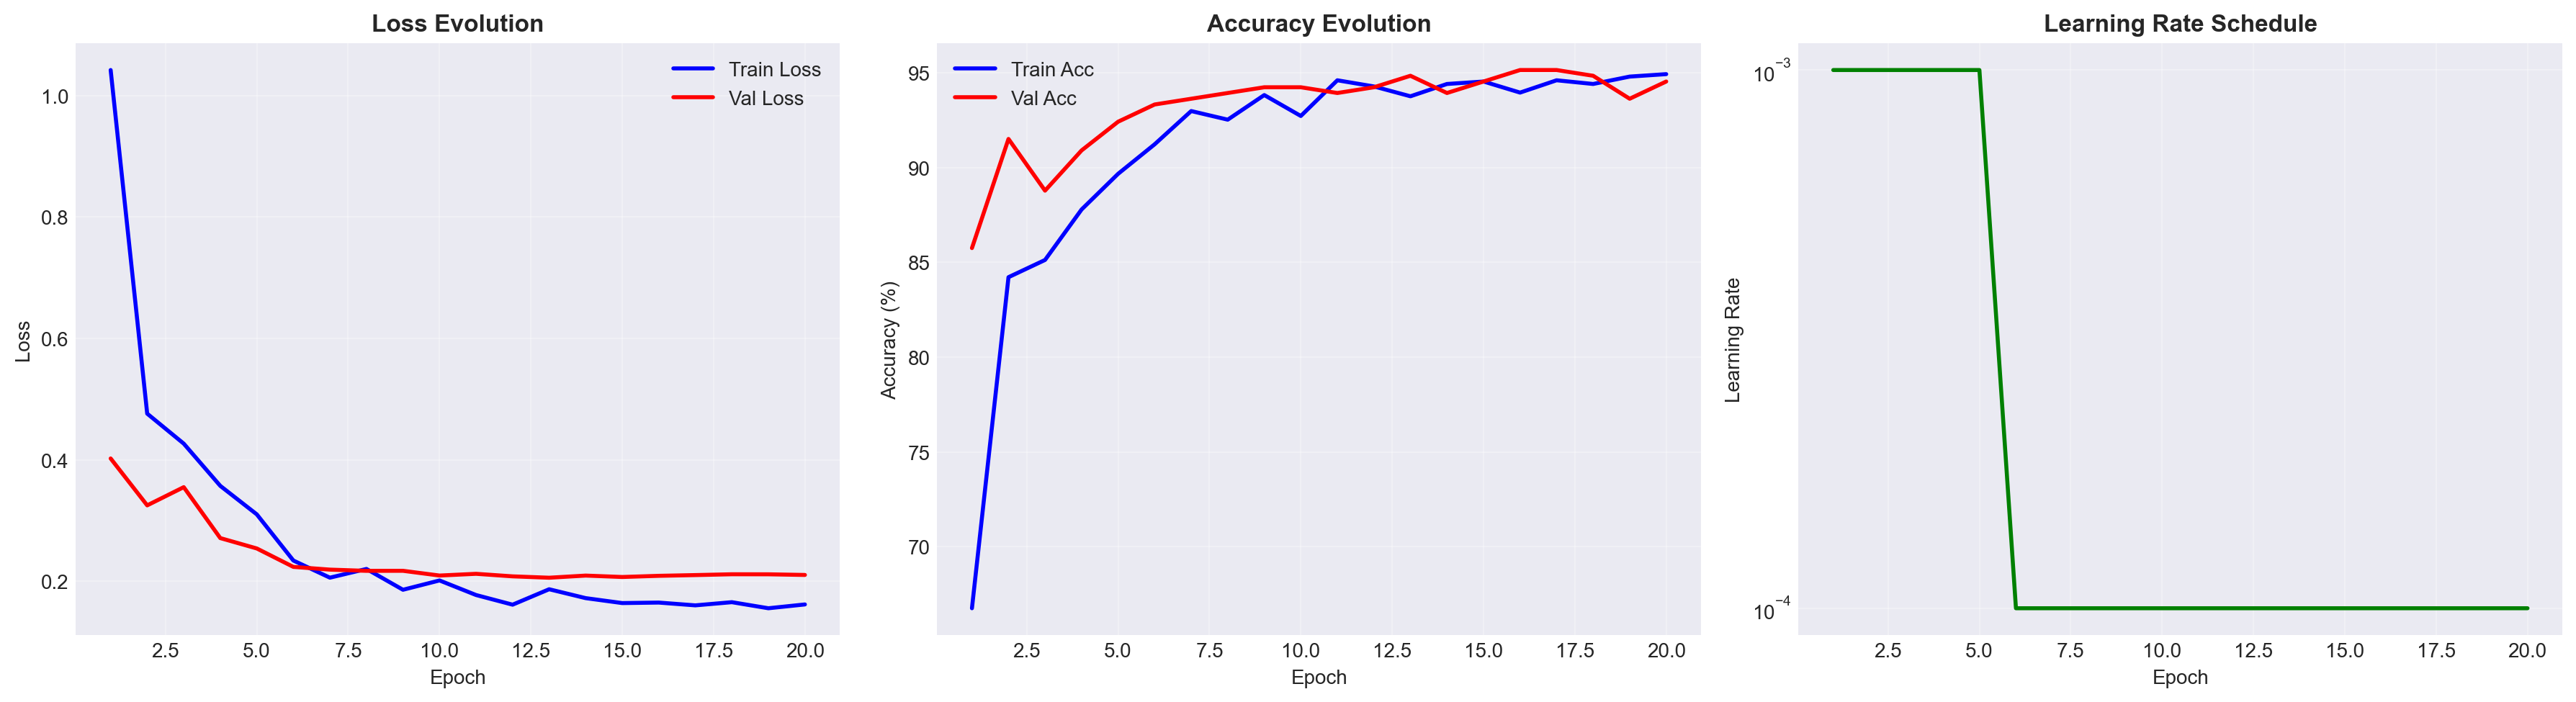

In [ ]:
def plot_training_history(history, save_path=None):
    """
    Visualise les courbes d'entraînement.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Evolution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Accuracy Evolution', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule', fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Graphique sauvegardé: {save_path}")
    
    plt.show()

# Visualiser
plot_training_history(history, save_path=RESULTS_DIR / 'training_curves.png')

## 10. Évaluation sur le Test Set

In [ ]:
# Charger le meilleur modèle
model.load_state_dict(best_model_wts)
model.eval()

print("Évaluation sur le test set...\n")

# Prédictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test'):
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculer les métriques
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✓ Test Accuracy: {test_acc*100:.2f}%")

Évaluation sur le test set...



Test:   0%|          | 0/21 [00:00<?, ?it/s]


✓ Test Accuracy: 94.85%


In [ ]:
# Rapport de classification
print("\n" + "="*80)
print("RAPPORT DE CLASSIFICATION")
print("="*80 + "\n")

report = classification_report(
    all_labels,
    all_preds,
    labels=range(NUM_CLASSES),
    target_names=SPICE_CLASSES,
    digits=4,
    zero_division=0
)
print(report)

# Sauvegarder le rapport
with open(RESULTS_DIR / 'classification_report.txt', 'w') as f:
    f.write(report)
print(f"✓ Rapport sauvegardé: {RESULTS_DIR / 'classification_report.txt'}")


RAPPORT DE CLASSIFICATION

              precision    recall  f1-score   support

        anis     0.9667    0.9667    0.9667        30
    cannelle     0.9667    0.9667    0.9667        30
       carvi     1.0000    1.0000    1.0000        30
clou_girofle     0.9333    0.9333    0.9333        30
      cubebe     0.9677    1.0000    0.9836        30
       cumin     0.9000    0.9000    0.9000        30
     curcuma     0.9310    0.9000    0.9153        30
   gingembre     1.0000    0.9667    0.9831        30
     paprika     0.9375    1.0000    0.9677        30
 poivre noir     0.8966    0.8667    0.8814        30
      safran     0.9333    0.9333    0.9333        30

    accuracy                         0.9485       330
   macro avg     0.9484    0.9485    0.9483       330
weighted avg     0.9484    0.9485    0.9483       330

✓ Rapport sauvegardé: C:\Users\zaineb\Desktop\spices 5-2\mobilenet_results\classification_report.txt


✓ Matrice sauvegardée: C:\Users\zaineb\Desktop\spices 5-2\mobilenet_results\confusion_matrix.png


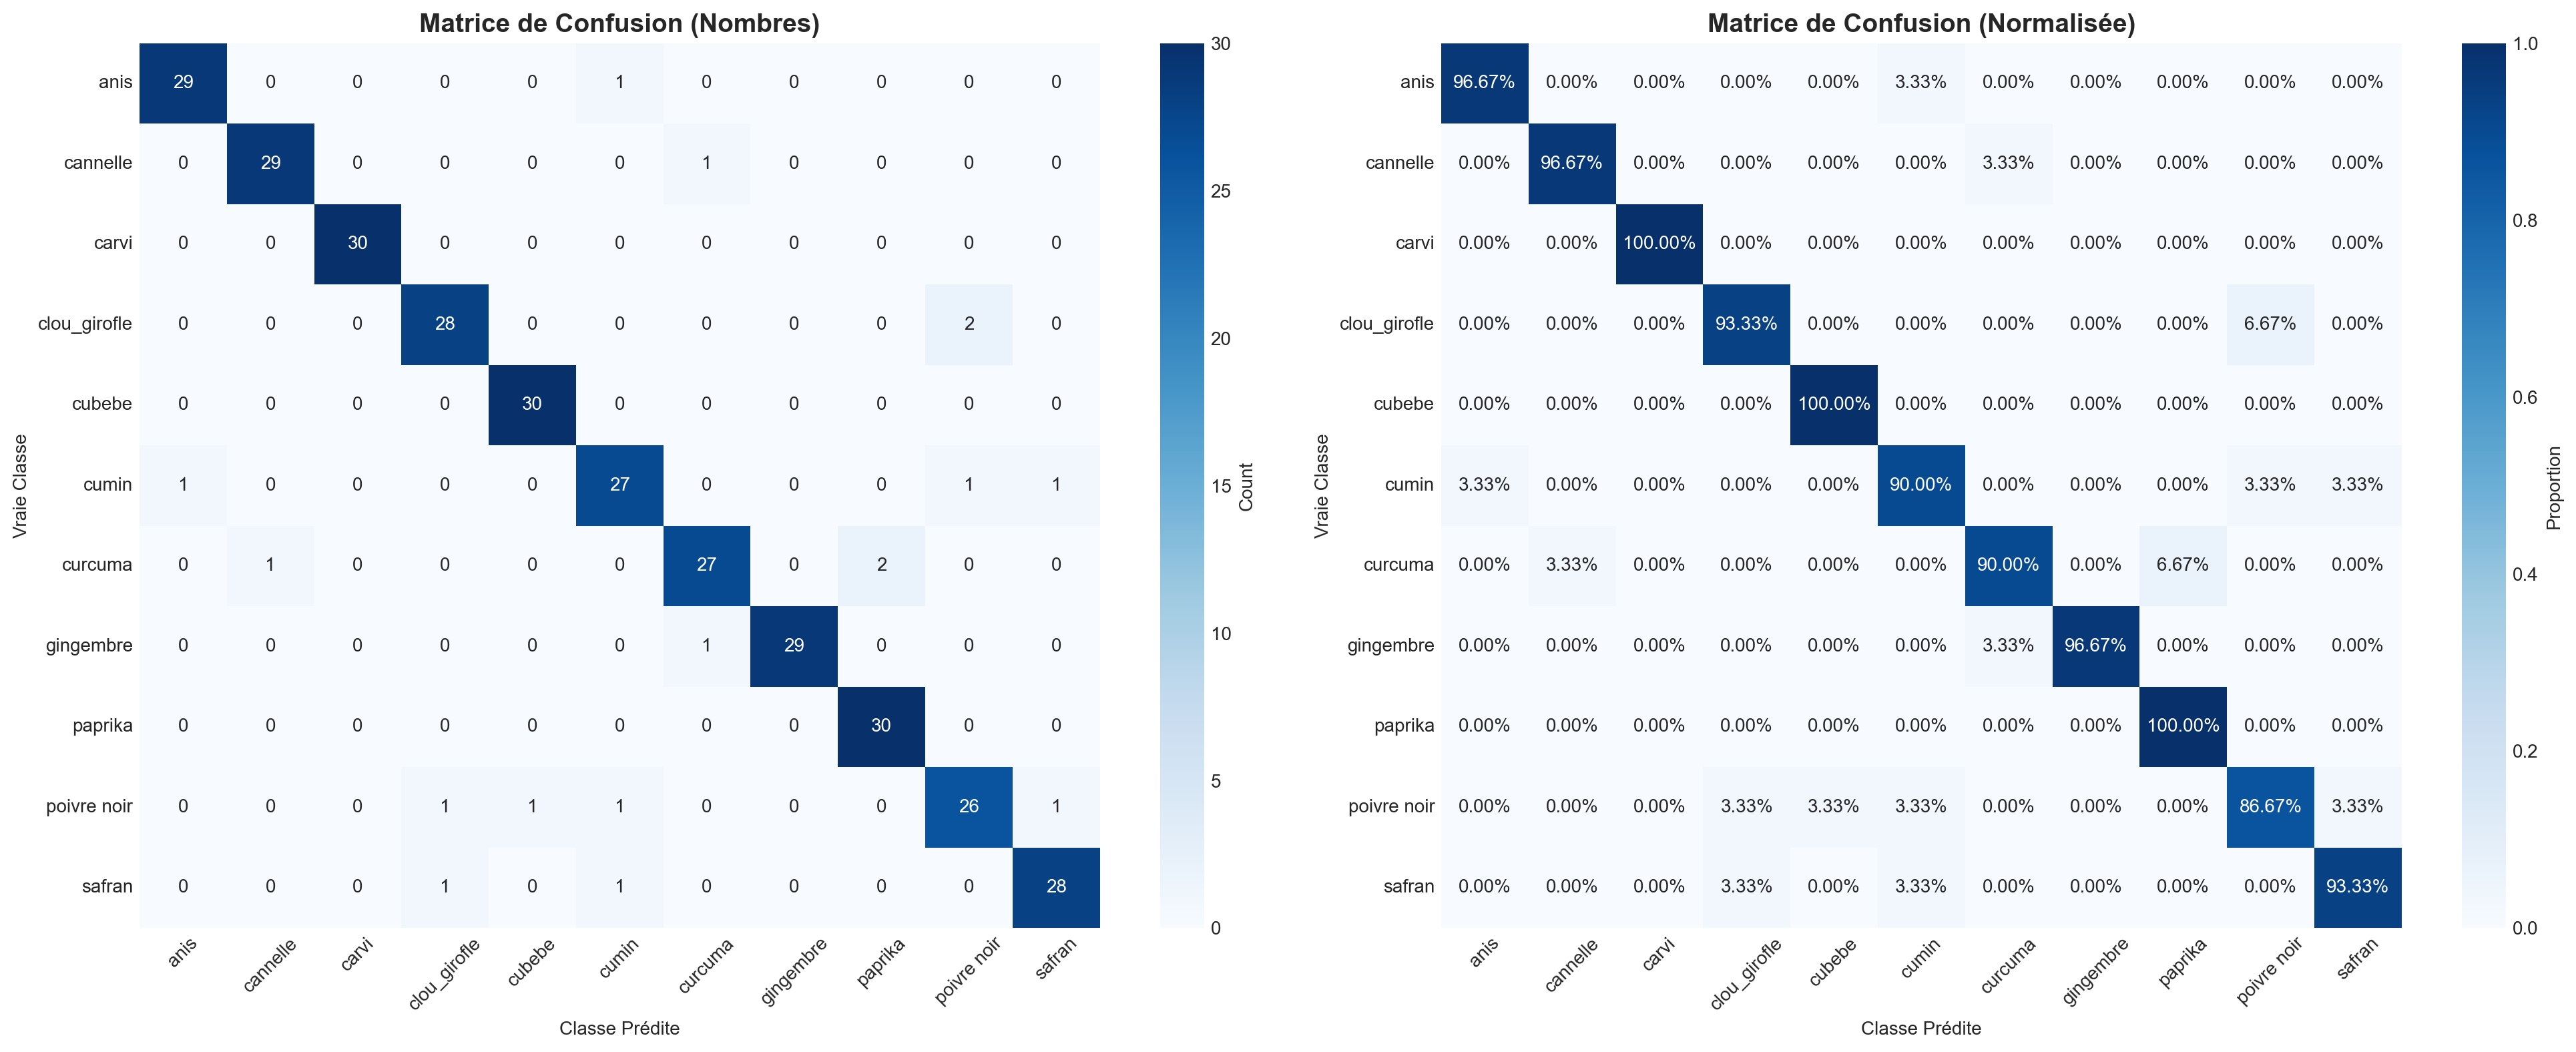

In [ ]:
# Matrice de confusion
def plot_confusion_matrix(y_true, y_pred, classes, save_path=None):
    """
    Affiche la matrice de confusion.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Normaliser
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Matrice brute
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Matrice de Confusion (Nombres)', fontweight='bold', fontsize=14)
    axes[0].set_ylabel('Vraie Classe')
    axes[0].set_xlabel('Classe Prédite')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Matrice normalisée
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title('Matrice de Confusion (Normalisée)', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('Vraie Classe')
    axes[1].set_xlabel('Classe Prédite')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Matrice sauvegardée: {save_path}")
    
    plt.show()

# Afficher
plot_confusion_matrix(
    all_labels,
    all_preds,
    SPICE_CLASSES,
    save_path=RESULTS_DIR / 'confusion_matrix.png'
)

## 11. Métriques Par Classe

In [ ]:
# Calculer les métriques par classe
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels,
    all_preds,
    labels=range(NUM_CLASSES),
    average=None,
    zero_division=0
)

# Créer un DataFrame
metrics_df = pd.DataFrame({
    'Classe': SPICE_CLASSES,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Calculer l'accuracy par classe
class_accuracies = []
for i in range(len(SPICE_CLASSES)):
    mask = np.array(all_labels) == i
    if mask.sum() > 0:
        acc = (np.array(all_preds)[mask] == i).sum() / mask.sum()
        class_accuracies.append(acc)
    else:
        class_accuracies.append(0)

metrics_df['Accuracy'] = class_accuracies

# Réorganiser les colonnes
metrics_df = metrics_df[['Classe', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']]

# Afficher
print("\n" + "="*80)
print("MÉTRIQUES PAR CLASSE")
print("="*80 + "\n")
print(metrics_df.to_string(index=False))

# Sauvegarder
metrics_df.to_csv(RESULTS_DIR / 'per_class_metrics.csv', index=False)
print(f"\n✓ Métriques sauvegardées: {RESULTS_DIR / 'per_class_metrics.csv'}")


MÉTRIQUES PAR CLASSE

      Classe  Accuracy  Precision   Recall  F1-Score  Support
        anis  0.966667   0.966667 0.966667  0.966667       30
    cannelle  0.966667   0.966667 0.966667  0.966667       30
       carvi  1.000000   1.000000 1.000000  1.000000       30
clou_girofle  0.933333   0.933333 0.933333  0.933333       30
      cubebe  1.000000   0.967742 1.000000  0.983607       30
       cumin  0.900000   0.900000 0.900000  0.900000       30
     curcuma  0.900000   0.931034 0.900000  0.915254       30
   gingembre  0.966667   1.000000 0.966667  0.983051       30
     paprika  1.000000   0.937500 1.000000  0.967742       30
 poivre noir  0.866667   0.896552 0.866667  0.881356       30
      safran  0.933333   0.933333 0.933333  0.933333       30

✓ Métriques sauvegardées: C:\Users\zaineb\Desktop\spices 5-2\mobilenet_results\per_class_metrics.csv


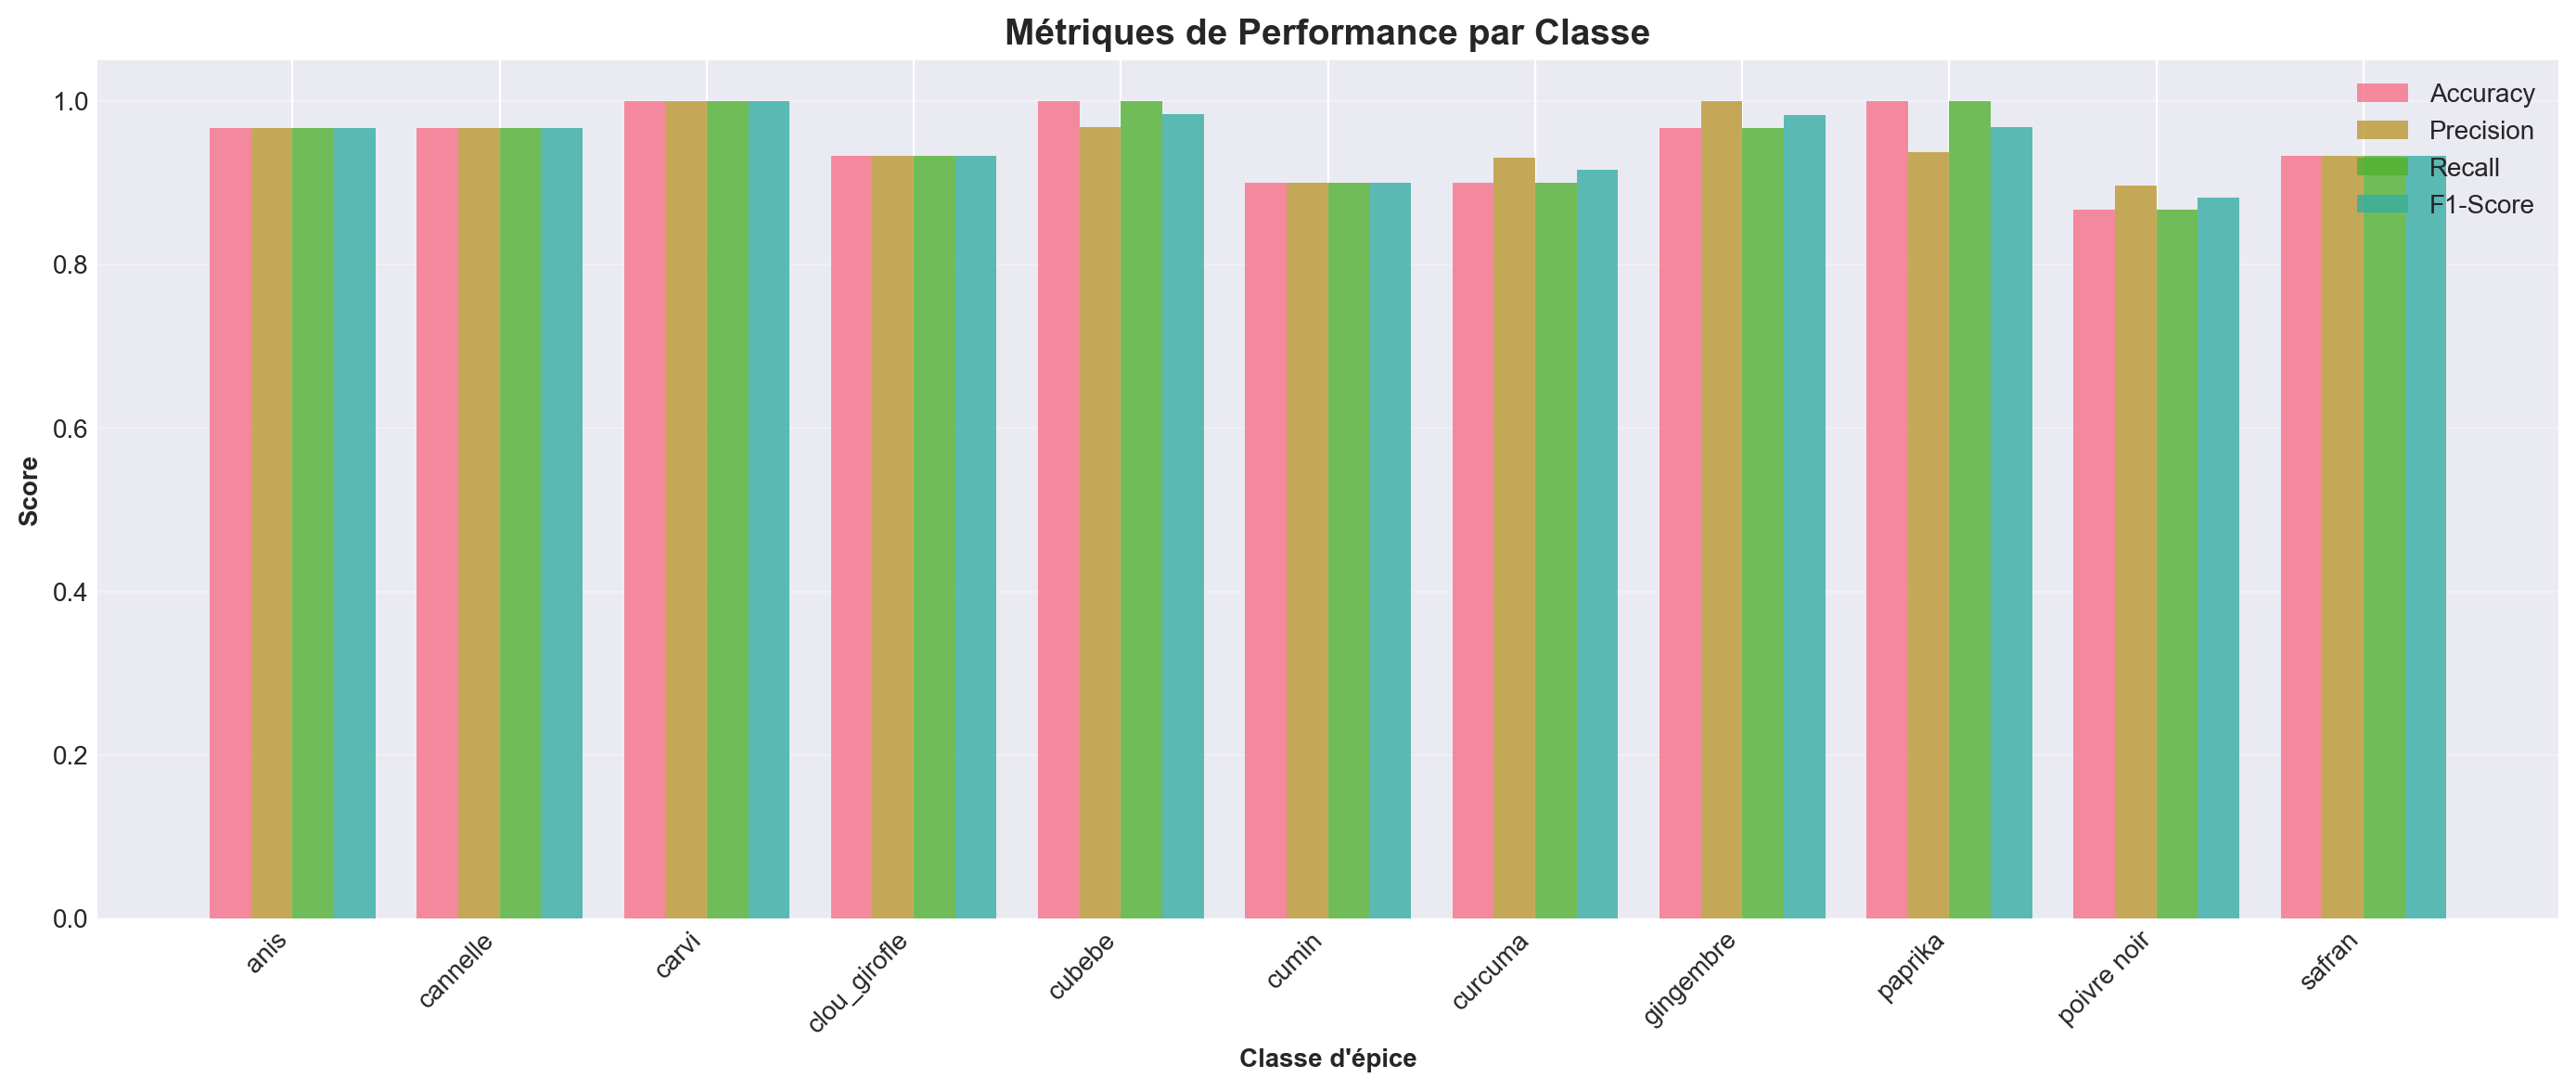

✓ Graphique sauvegardé: C:\Users\zaineb\Desktop\spices 5-2\mobilenet_results\per_class_metrics.png


In [ ]:
# Visualiser les métriques par classe
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(SPICE_CLASSES))
width = 0.2

ax.bar(x - width*1.5, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x - width*0.5, metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x + width*0.5, metrics_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width*1.5, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Classe d\'épice', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Métriques de Performance par Classe', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(SPICE_CLASSES, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graphique sauvegardé: {RESULTS_DIR / 'per_class_metrics.png'}")

In [ ]:
# Sauvegarder les resultats pour comparaison inter-modeles
results = {
    'model': 'MobileNetV3-Large',
    'best_val_acc': float(best_val_acc),
    'test_acc': float(test_acc * 100),
    'num_params': int(total_params),
    'trainable_params': int(trainable_params),
    'history': history
}

results_path = MODELS_DIR / 'results_mobilenet.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Resultats sauvegardes dans {results_path}")

## 12. Sauvegarde du Rapport Final

In [ ]:
# Générer un rapport complet
report_text = f"""
{'='*80}
RAPPORT D'ENTRAÎNEMENT - MOBILENETV3
Classification d'Épices Marocaines
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}

1. CONFIGURATION
{'-'*80}
Architecture: MobileNetV3-Large
Transfer Learning: ImageNet pré-entraîné
Nombre de classes: {NUM_CLASSES}
Classes: {', '.join(SPICE_CLASSES)}

Hyperparamètres:
  - Image size: {CONFIG['image_size']}×{CONFIG['image_size']}
  - Batch size: {CONFIG['batch_size']}
  - Initial learning rate: {CONFIG['learning_rate']}
  - Weight decay: {CONFIG['weight_decay']}
  - Epochs trained: {len(history['train_loss'])}
  - Total parameters: {total_params:,}
  - Trainable parameters: {trainable_params:,}

2. DONNÉES
{'-'*80}
Train set: {len(train_dataset)} images
Validation set: {len(val_dataset)} images
Test set: {len(test_dataset)} images
Total: {len(train_dataset) + len(val_dataset) + len(test_dataset)} images

Augmentation (training):
  - Random Horizontal Flip (50%)
  - Random Vertical Flip (30%)
  - Random Rotation (±20°)
  - Color Jitter
  - Random Affine

3. RÉSULTATS D'ENTRAÎNEMENT
{'-'*80}
Meilleure validation accuracy: {best_val_acc:.2f}%
Test accuracy: {test_acc*100:.2f}%
Temps total d'entraînement: {total_time/60:.1f} minutes

Dernière epoch:
  - Train Loss: {history['train_loss'][-1]:.4f}
  - Train Acc: {history['train_acc'][-1]:.2f}%
  - Val Loss: {history['val_loss'][-1]:.4f}
  - Val Acc: {history['val_acc'][-1]:.2f}%

4. MÉTRIQUES GLOBALES (TEST SET)
{'-'*80}
"""

# Ajouter les métriques moyennes
report_text += f"""Precision moyenne: {precision.mean():.4f}
Recall moyen: {recall.mean():.4f}
F1-Score moyen: {f1.mean():.4f}

5. TOP ET BOTTOM CLASSES
{'-'*80}
"""

# Top 3 classes
top_3 = metrics_df.nlargest(3, 'F1-Score')
report_text += "\nMeilleures performances (F1-Score):\n"
for idx, row in top_3.iterrows():
    report_text += f"  {idx+1}. {row['Classe']}: {row['F1-Score']:.4f}\n"

# Bottom 3 classes
bottom_3 = metrics_df.nsmallest(3, 'F1-Score')
report_text += "\nPerformances les plus faibles (F1-Score):\n"
for idx, row in bottom_3.iterrows():
    report_text += f"  {idx+1}. {row['Classe']}: {row['F1-Score']:.4f}\n"

report_text += f"""
6. FICHIERS GÉNÉRÉS
{'-'*80}
Modèle: {MODELS_DIR / 'model_mobilenetv3.pth'}
Courbes d'entraînement: {RESULTS_DIR / 'training_curves.png'}
Matrice de confusion: {RESULTS_DIR / 'confusion_matrix.png'}
Rapport de classification: {RESULTS_DIR / 'classification_report.txt'}
Métriques par classe: {RESULTS_DIR / 'per_class_metrics.csv'}

{'='*80}
FIN DU RAPPORT
{'='*80}
"""

# Sauvegarder
with open(RESULTS_DIR / 'training_report.txt', 'w', encoding='utf-8') as f:
    f.write(report_text)

print(report_text)
print(f"\n✓ Rapport complet sauvegardé: {RESULTS_DIR / 'training_report.txt'}")


RAPPORT D'ENTRAÎNEMENT - MOBILENETV3
Classification d'Épices Marocaines
Date: 2026-02-06 03:45:36

1. CONFIGURATION
--------------------------------------------------------------------------------
Architecture: MobileNetV3-Large
Transfer Learning: ImageNet pré-entraîné
Nombre de classes: 11
Classes: anis, cannelle, carvi, clou_girofle, cubebe, cumin, curcuma, gingembre, paprika, poivre noir, safran

Hyperparamètres:
  - Image size: 224×224
  - Batch size: 16
  - Initial learning rate: 0.001
  - Weight decay: 0.0001
  - Epochs trained: 20
  - Total parameters: 4,216,123
  - Trainable parameters: 4,216,123

2. DONNÉES
--------------------------------------------------------------------------------
Train set: 1540 images
Validation set: 330 images
Test set: 330 images
Total: 2200 images

Augmentation (training):
  - Random Horizontal Flip (50%)
  - Random Vertical Flip (30%)
  - Random Rotation (±20°)
  - Color Jitter
  - Random Affine

3. RÉSULTATS D'ENTRAÎNEMENT
-----------------------

## 13. Fonction de Prediction pour de Nouvelles Images

In [ ]:
def predict_image(image_path, model, transform, device, classes):
    """
    Prédit la classe d'une nouvelle image.
    
    Args:
        image_path: Chemin vers l'image
        model: Modèle entraîné
        transform: Transformations à appliquer
        device: CPU ou GPU
        classes: Liste des noms de classes
    
    Returns:
        predicted_class: Classe prédite
        confidence: Confiance de la prédiction
        all_probs: Probabilités pour toutes les classes
    """
    model.eval()
    
    # Charger et préparer l'image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = probabilities.max(1)
    
    predicted_class = classes[predicted.item()]
    confidence = confidence.item()
    all_probs = probabilities.cpu().numpy()[0]
    
    return predicted_class, confidence, all_probs


# Exemple d'utilisation
def visualize_prediction(image_path, model, transform, device, classes):
    """
    Visualise une prédiction.
    """
    predicted_class, confidence, all_probs = predict_image(
        image_path, model, transform, device, classes
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Image
    image = Image.open(image_path)
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title(f'Prédiction: {predicted_class}\nConfiance: {confidence*100:.2f}%',
                     fontsize=12, fontweight='bold')
    
    # Barplot des probabilités
    axes[1].barh(classes, all_probs, color='skyblue')
    axes[1].set_xlabel('Probabilité')
    axes[1].set_title('Probabilités par Classe', fontsize=12, fontweight='bold')
    axes[1].set_xlim([0, 1])
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence

print("✓ Fonctions de prédiction définies")
print("\nPour prédire une nouvelle image, utilisez:")
print("  visualize_prediction('chemin/vers/image.jpg', model, val_test_transforms, device, SPICE_CLASSES)")

✓ Fonctions de prédiction définies

Pour prédire une nouvelle image, utilisez:
  visualize_prediction('chemin/vers/image.jpg', model, val_test_transforms, device, SPICE_CLASSES)


## 14. Resume Final

In [ ]:
print("\n" + "="*80)
print("✓ ENTRAÎNEMENT ET ÉVALUATION TERMINÉS AVEC SUCCÈS!")
print("="*80)

print(f"\n📊 Résultats Finaux:")
print(f"  • Meilleure Val Accuracy: {best_val_acc:.2f}%")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Temps d'entraînement: {total_time/60:.1f} minutes")

print(f"\n📁 Fichiers générés dans {RESULTS_DIR}/:")
for file in sorted(RESULTS_DIR.glob('*')):
    print(f"  • {file.name}")

print(f"\n💾 Modèle sauvegardé:")
print(f"  • {MODELS_DIR / 'model_mobilenetv3.pth'}")

print("\n🎯 Prochaines étapes suggérées:")
print("  1. Analyser la matrice de confusion pour identifier les confusions")
print("  2. Tester le modèle sur de nouvelles images")
print("  3. Exporter le modèle pour déploiement (ONNX, TorchScript)")
print("  4. Créer une application de démonstration")
print("="*80)


✓ ENTRAÎNEMENT ET ÉVALUATION TERMINÉS AVEC SUCCÈS!

📊 Résultats Finaux:
  • Meilleure Val Accuracy: 95.15%
  • Test Accuracy: 94.85%
  • Temps d'entraînement: 117.0 minutes

📁 Fichiers générés dans C:\Users\zaineb\Desktop\spices 5-2\mobilenet_results/:
  • classification_report.txt
  • confusion_matrix.png
  • per_class_metrics.csv
  • per_class_metrics.png
  • training_curves.png
  • training_report.txt

💾 Modèle sauvegardé:
  • C:\Users\zaineb\Desktop\spices 5-2\models\model_mobilenetv3.pth

🎯 Prochaines étapes suggérées:
  1. Analyser la matrice de confusion pour identifier les confusions
  2. Tester le modèle sur de nouvelles images
  3. Exporter le modèle pour déploiement (ONNX, TorchScript)
  4. Créer une application de démonstration
